In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd
import math
import scipy

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

Text(0.5,1,'Tracer')

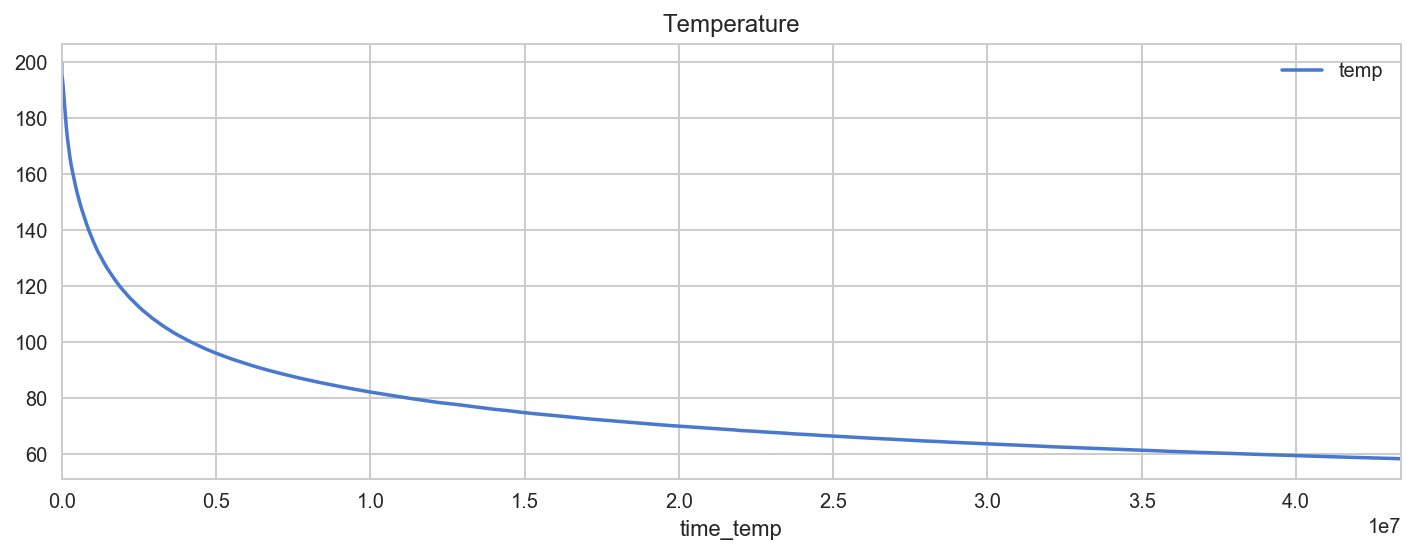

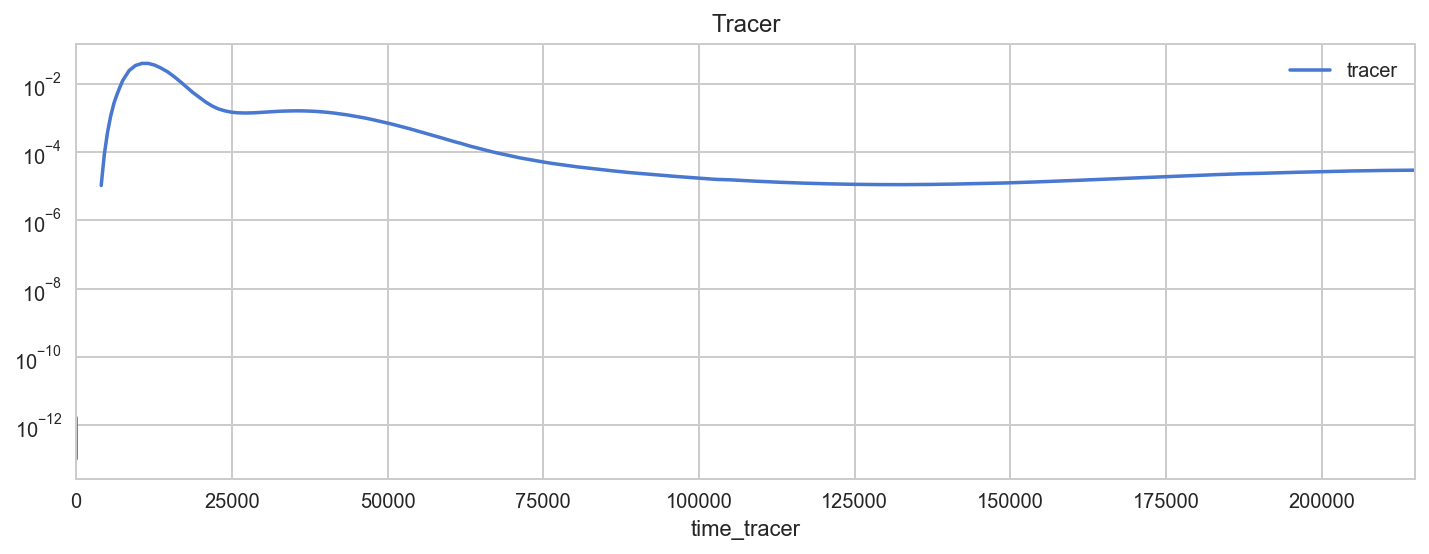

In [32]:
### Observation data  ###
df = pd.read_csv('temp6.csv', header=-1,names=('time_temp','temp'))
df.plot(x='time_temp',y='temp',figsize=(12,4))
plt.title("Temperature")

df2 = pd.read_csv('tracer6.csv', header=-1,names=('time_tracer','tracer'))
df2.plot(x='time_tracer',y='tracer',figsize=(12,4),logy=True,logx=False)
plt.title("Tracer")

In [33]:
#### Rock and Water Properties ########
DensityWater25 = 997.1 #[kg/m3]
DensityWater200= 864   #[kg/m3]
HeatCapWater25 = 4180  #[J/kg K]
HeatCapWater200= 4510  #[J/kg K]

Temp_ini = 200 #[degC]
Temp_inj = 25  #[degC]

K_r = 2.569 #[J/s m K]
DensityRcok = 2716 #[kg/m3]
HeatCapRock = 803 #[J/kg K]
Poro_frac = 0.74
#Poro_frac= 0.9
kappa= K_r/DensityRcok/HeatCapRock
AveDensityWater = DensityWater200
AveHeatCapWater = HeatCapWater200
Rho_rC_r = DensityRcok*HeatCapRock
Rho_wC_w = DensityWater200*HeatCapWater200
Rho_aC_a = (1-Poro_frac)*Rho_rC_r+ Poro_frac*Rho_wC_w
########################################

###### Injection Condition #############
MassRateInjectedWater  = 2.0 # [kg/s]
MassRateInjectedTracer = 0.2 # [kg/s]
TimeInjectedTracer = 1 * 3600 # 1 hour * sec/hour [s]
########################################

MassRateProducedWater = 2.0 # [kg/s]

NumFraction = 6


In [34]:
# Calculate flow rate, q, pore volume, Vp, from tracer data
class Tracer_q_Vp(object):
    def __init__(self, df, NumFraction):
        self.df=df
        self.NumFraction = NumFraction
    
    def mathlog(self,x):
        if x >0:
            return math.log(x)
        else:
            return 0
        
    
    def Recoveryrate(self):
        df3=self.df
        # delta_t b/w [tn, tn+1]
        df3['DT'] =pd.Series(np.diff(df3.time_tracer)).shift(1)
        # delta_c b/w [tn, tn+1]
        df3['DC']= pd.Series(np.diff(df3.tracer)).shift(1)
        # average value of t in [tn, tn+1]
        df3['AveT']=(df3.time_tracer+df3.time_tracer.shift(1))/2
        # average value of c in [tn, tn+1]        
        df3['AveC']=(df3.tracer+df3.tracer.shift(1))/2
        # c delta_t at tn
        df3['AveCDT']=df3.AveC*df3.DT
        # ct delta_t at tn
        df3['AveCAveTDT']=df3.AveC*df3.AveT*df3.DT
        self.df4=pd.DataFrame()
        self.df4['IntAveCDT']=df3.AveCDT
        self.df4['IntAveCAveTDT']=df3.AveCAveTDT
        for n in range (2, len(df3.index)-1):
            # Sigma c delta_t in [0, tn]
            self.df4['IntAveCDT'][n]= self.df4.IntAveCDT[n-1] +df3.AveCDT[n]
            # Sigma ct delta_t in [0, tn]
            self.df4['IntAveCAveTDT'][n]= self.df4.IntAveCAveTDT[n-1] +df3.AveCAveTDT[n]
        
        # Sigma c delta_t in [0, infinity]		
        TotalMassProducedTracer = self.df4.IntAveCDT[len(df3.index)-2]
        # Flow capacity 
        self.df4['F']=self.df4['IntAveCDT']/self.df4['IntAveCDT'][len(df3.index)-2]
        # Storage capacity
        self.df4['Phi']=self.df4['IntAveCAveTDT']/self.df4['IntAveCAveTDT'][len(df3.index)-2]
        #Arithmetic mean
        AveTravelTime = self.df4['IntAveCAveTDT'][len(df3.index)-2] / self.df4['IntAveCDT'][len(df3.index)-2]
        MassInjectedTracer = MassRateInjectedTracer * TimeInjectedTracer #[kg]
        self.RecoveryRate = TotalMassProducedTracer / MassInjectedTracer #[kg / kg] 
        self.Q_in = MassRateInjectedWater / DensityWater25 #[m3/s]
        self.Q_prod = MassRateProducedWater / DensityWater25 #[m3/s]
        self.Darcy_Q = Poro_frac * self.Q_prod
        self.Q_sur_in = self.Q_prod - self.RecoveryRate * self.Q_in #[m3/s]
        self.Q_sur_out = (1-self.RecoveryRate)*self.Q_in #[m3/s]
        print("Recovery rate={0:07.5f}, TotalMassProducedTracer={1:08.5f}".format(self.RecoveryRate,TotalMassProducedTracer))        
        
    def Frac_id_from_data(self,Frac_Phi):
        nd=0
        Frac_id=np.zeros(self.NumFraction+1)
        for n in range (0, len(self.df4.index)-1):
            if(self.df4.Phi[n]>=1):
                Frac_id[nd]=n
                break
            if(self.df4.Phi[n]>= Frac_Phi[nd]):              
                Frac_id[nd]=n
                nd=nd+1
                if (nd > NumFraction+1):
                    break
        return Frac_id.astype(int)
    
    def func_id(self,func,id):
        Frac_func=np.zeros(len(id))
        for n in range (len(id)):
            Frac_func[n]=func[id[n]]       
        return Frac_func
    

    def frac_q_vp(self):
        self.Recoveryrate()
        df5 = pd.DataFrame()
        df5['F']=np.arange(0,1.1,1/self.NumFraction)
        df5['id']=self.Frac_id_from_data(df5.F)
        df5['Phi']=self.func_id(self.df4.Phi,df5.id)
        df5['IntAveCDT']=self.func_id(self.df4.IntAveCDT,df5.id)
        df5['IntAveCAveTDT']=self.func_id(self.df4.IntAveCAveTDT,df5.id)

        df6 = pd.DataFrame()        
        df6['DF']=np.diff(df5.F)
        df6['DPhi']=np.diff(df5.Phi)
        df6['DIntAveCDT']=np.diff(df5.IntAveCDT)
        df6['DIntAveCAveTDT']=np.diff(df5.IntAveCAveTDT)


        # Arizmetic mean
        df6['AveTravelTime'] = df6.DIntAveCAveTDT/df6.DIntAveCDT


        df6['Q'] =df6.DF * self.Q_prod #[m3]
        df6['Darcy_Q'] =df6.Q * Poro_frac #[m3]        
        df6['Cum_Q']=np.zeros(len(df6.index))
        df6.Cum_Q[0]=df6.Q[0]
        for n in range(1,NumFraction):
            df6.Cum_Q[n]= df6.Cum_Q[n-1] +df6.Q[n] 

        df6['Vp']= df6.DF * self.Q_prod * df6.AveTravelTime  #[m3]
        df6['Cum_Vp']=np.zeros(len(df6.index))        
        df6.Cum_Vp[0]=df6.Vp[0]
        for n in range(1,NumFraction):
            df6.Cum_Vp[n]= df6.Cum_Vp[n-1] +df6.Vp[n] 

        self.DF=df6.DF
        self.Q=df6.Q
        self.Vp=df6.Vp
        return df6
            

In [35]:
qVp=Tracer_q_Vp(df2,NumFraction)
qVp.frac_q_vp()


Recovery rate=0.48604, TotalMassProducedTracer=349.94618


,DF,DPhi,DIntAveCDT,DIntAveCAveTDT,AveTravelTime,Q,Darcy_Q,Cum_Q,Vp,Cum_Vp
0,0.166667,0.231924,140.335478,1.346006e+06,9591.342545,0.000334,0.000247,0.000334,3.206413,3.206413
1,0.166667,0.152226,70.325000,8.834649e+05,12562.600942,0.000334,0.000247,0.000669,4.199713,7.406126
2,0.166667,0.121146,48.231800,7.030887e+05,14577.284971,0.000334,0.000247,0.001003,4.873227,12.279353
3,0.166667,0.165755,51.050611,9.619812e+05,18843.676671,0.000334,0.000247,0.001337,6.299494,18.578847
4,0.166667,0.169997,27.428445,9.866046e+05,35970.123744,0.000334,0.000247,0.001672,12.024913,30.603761
5,0.166667,0.158953,12.574847,9.225055e+05,73361.170468,0.000334,0.000247,0.002006,24.524846,55.128606


In [36]:
#Calculate temperature decline using q and Vp from tracer data
class Temp_from_tracer(Tracer_q_Vp):
    def __init__(self,Frac_A,Vp,Darcy_Q,DF):
        self.Darcy_Q=Darcy_Q
        self.Vp=Vp
        self.Frac_A = Frac_A
        self.DF=DF
        
    def Temp(self,time,Vp,Darcy_q,A):
        ##### Analytical solution of heat transfer eq. #############
        ##### Eq. (7) in Shook and Suzuki, Geothermics (2017) ######
        if time-Rho_aC_a/Rho_wC_w*Vp/Poro_frac/Darcy_q>0:
            return scipy.special.erfc(A/2/ Darcy_q * np.sqrt(K_r*Rho_rC_r)/ Rho_wC_w  / np.sqrt(time-Rho_aC_a/Rho_wC_w*Vp/Poro_frac/Darcy_q))
        else:
            return 0
            
        
        
    def Total_Temp(self,time):
        TT=np.zeros(NumFraction)
        for n in range(NumFraction):
            TT[n] = self.Temp(time, self.Vp[n], self.Darcy_Q[n], self.Frac_A[n]) * self.DF[n]
        return (1-sum(TT)) * (Temp_ini-Temp_inj) + Temp_inj
    

In [37]:
Frac_A=np.ones(NumFraction)*1000
qVp=Tracer_q_Vp(df2,NumFraction)
f=qVp.frac_q_vp()
Frac_Vp=f.Vp
Frac_Darcy_Q=f.Darcy_Q
Frac_F=f.DF

TempTra=Temp_from_tracer(Frac_A,Frac_Vp,Frac_Darcy_Q,Frac_F)
#df.time_temp
# for t in range (len(df.time_temp)):
#     TempTra.Total_Temp(df.time_temp[t])
# print(TempTra.Total_Temp(df.time_temp[len(df.time_temp)-1]))

Recovery rate=0.48604, TotalMassProducedTracer=349.94618


In [56]:
# Optimize surface area, A, by particle filter method
class ParticleFilter(object):
    def __init__(self, time, observation, Frac_Vp, Frac_Darcy_Q,Frac_F, n_particle, sigma_2, alpha_2, initial_A):
        self.time=time
        self.observation = observation
        self.Frac_Vp=Frac_Vp
        self.Frac_Darcy_Q=Frac_Darcy_Q
        self.Frac_F=Frac_F
        self.n_particle = n_particle
        self.sigma_2 = sigma_2
        self.alpha_2 = alpha_2
        self.log_likelihood = -np.inf
        self.initial_A=initial_A
    
    def norm_likelihood(self, observation, x, s2):
        return (np.sqrt(2*np.pi*s2))**(-1) * np.exp(-(observation-x)**2/(2*s2))

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                return 0
            k = np.max(idx[w_cumsum < u])
            return k+1
        
    def resampling(self, weights):
        w_cumsum = np.cumsum(weights)
        idx = np.asanyarray(range(self.n_particle))
        k_list = np.zeros(self.n_particle, dtype=np.int32) # サンプリングしたkのリスト格納場所
        
        # 一様分布から重みに応じてリサンプリングする添え字を取得
        for i, u in enumerate(rd.uniform(0, 1, size=self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def resampling2(self, weights):
        """
        計算量の少ない層化サンプリング
        """
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1/self.n_particle)
        u = [1/self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k.astype(int)
    
    def simulate(self, seed=71):
        rd.seed(seed)

        # 時系列データ数
        T = len(self.time)
        
        # 潜在変数
        x = np.zeros((T+1,NumFraction, self.n_particle))        
        x_resampled = np.zeros((T+1, NumFraction, self.n_particle))
        
        # 潜在変数の初期値
        initial_x = np.zeros((NumFraction,self.n_particle))
        initial_x = rd.normal(self.initial_A, self.initial_A, size=(NumFraction,self.n_particle))
        x_resampled[0] = initial_x
        x[0] = initial_x        

        # 重み
        w        = np.zeros((T, NumFraction, self.n_particle))
        w_normed = np.zeros((T, NumFraction, self.n_particle))

        l = np.zeros((T, NumFraction)) # 時刻毎の尤度
        self.Est_data=np.zeros((T,self.n_particle))

        for t in range(T):
            print("\r calculating... t={0}  temp={1:.1f}".format(t,self.observation[t]), end="")
            for i in range(self.n_particle):
                temp_A=np.zeros(NumFraction)
                for nFrac in range(NumFraction):
                    v = rd.normal(0, np.sqrt(self.alpha_2*self.sigma_2)) # System Noise
                    x[t+1, nFrac, i] = x_resampled[t, nFrac, i] + v # システムノイズの付加
                    if x[t+1, nFrac, i]<0:
                        x[t+1, nFrac, i]=0.0
                temp_A=x[t+1,:,i]
#             temp_id=np.zeros((self.n_particle, NumFraction), dtype=np.int)            
#             for i in range(self.n_particle):
#                 for nFrac in range(NumFraction):                    
#                     if nFrac==0:
#                         temp_id[i,nFrac]=i
#                         temp_A[i,nFrac]=x[t+1, nFrac, i]                        
#                     else:
#                         temp_id[i,nFrac]=rd.randint(0,self.n_particle-1)
#                         temp_A[i,nFrac]=x[t+1, nFrac, temp_id[i,nFrac]]                            
                TempTra=Temp_from_tracer(temp_A, Frac_Vp, Frac_Darcy_Q, Frac_F)
                self.Est_data[t,i]=TempTra.Total_Temp(self.time[t])
                for nFrac in range(NumFraction):
                    w[t,nFrac,i] = self.norm_likelihood(self.observation[t], self.Est_data[t,i], self.sigma_2) # y[t]に対する各粒子の尤度
                
            for nFrac in range(NumFraction):
                w_normed[t,nFrac,:] = w[t,nFrac,:]/np.sum(w[t,nFrac,:]) # 規格化               
                l[t,nFrac] = np.log(np.sum(w[t,nFrac,:])) # 各時刻対数尤度
            
            # Resampling
            #k = self.resampling(w_normed[t]) # リサンプルで取得した粒子の添字
            k=np.zeros((NumFraction,self.n_particle),dtype=np.int)
            est_A=np.zeros((NumFraction,self.n_particle))
            for nFrac in range (NumFraction):                
                k[nFrac,:] = self.resampling2(w_normed[t,nFrac,:]) # リサンプルで取得した粒子の添字（層化サンプリング            
                for i in range(self.n_particle):
                    x_resampled[t+1,nFrac,i] = x[t+1,nFrac,k[nFrac,i]-1]
                est_A[nFrac,:]= x_resampled[t+1,nFrac,:] * w[t,nFrac,:]
            

        # 全体の対数尤度
        self.log_likelihood = np.sum(l) - T*np.log(n_particle)
        
        self.x = x
        self.x_resampled = x_resampled
        self.w = w
        self.w_normed = w_normed
        self.l = l
        
    def get_filtered_value(self,nFrac):
        """
        尤度の重みで加重平均した値でフィルタリングされ値を算出
        """            
        
        return np.diag(np.dot(self.w_normed[:,nFrac,:], self.x[1:,nFrac,:].T))
        
    def draw_graph(self):
        # グラフ描画
        T = len(self.observation)
        
        Total_A=np.zeros(T)
        plt.figure(figsize=(16,8))
        for nFrac in range(NumFraction):
            plt.plot(self.time, self.get_filtered_value(nFrac),label=format(nFrac)) 
            Total_A += self.get_filtered_value(nFrac)
        plt.plot(self.time, Total_A, label='Total')
        plt.plot(self.time, 6360*np.ones(T), label='Answer',color='black',linestyle='dashed',linewidth=3.0)
        plt.legend()
        plt.xlabel('Time (sec)')
        plt.ylabel('Surface area ($m^2$)')           
            
        plt.figure(figsize=(16,8))
        plt.plot(self.time, self.observation,label='Observation') 
                    
        for t in range(T):
            plt.scatter(np.ones(self.n_particle)*self.time[t], self.Est_data[t].T, s=2, alpha=0.1, label='Estimated value')
        
        plt.title("sigma^2={0}, alpha^2={1}, log likelihood={2:.3f}".format(self.sigma_2, 
                                                                                 self.alpha_2, 
                                                                                 self.log_likelihood))
        plt.xlabel('Time (sec)')
        plt.ylabel('Temperature ($C^o$)')           


        #plt.show()
    

In [78]:
# ハイパーパラメーター
a = 3
b = 2

n_particle = 10**3 
sigma_2 = 2**a
alpha_2 = 10**b
initial_A = 6360/6


In [79]:
pf = ParticleFilter(df.time_temp.values, df.temp.values, Frac_Vp, Frac_Darcy_Q,  Frac_F, n_particle, sigma_2, alpha_2, initial_A)

In [80]:
pf.simulate()

 calculating... t=156  temp=58.2

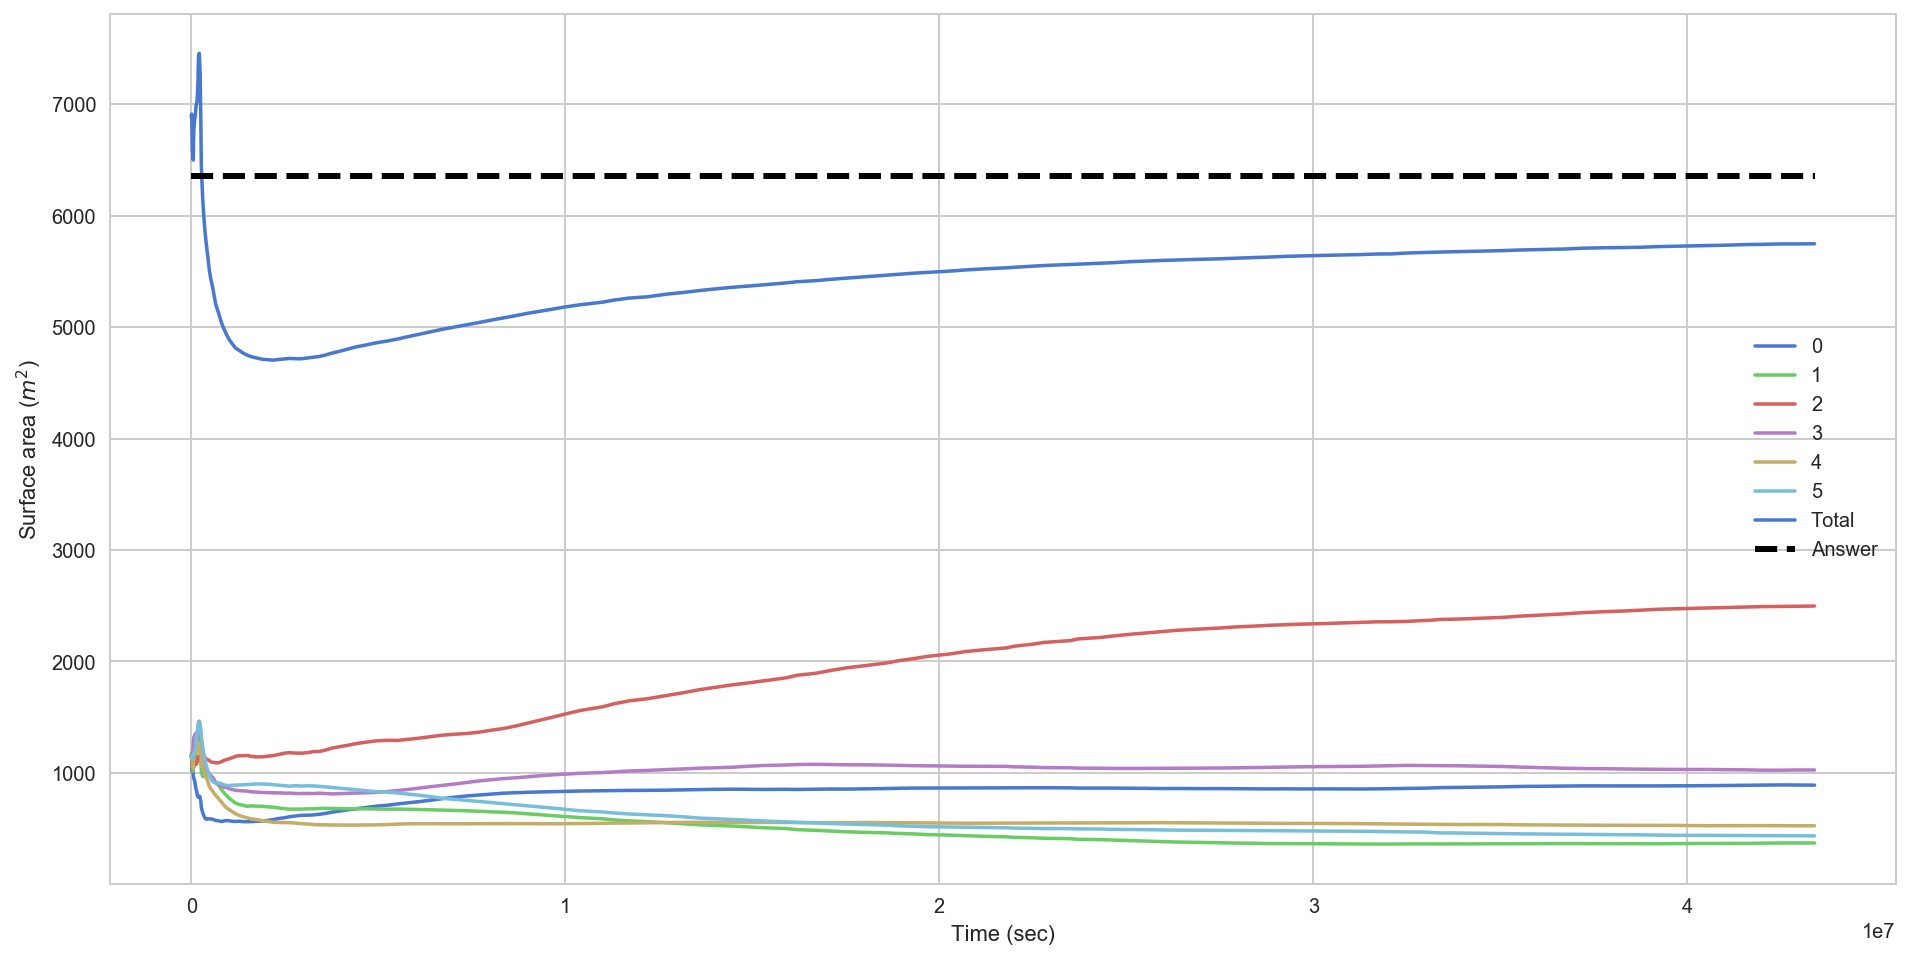

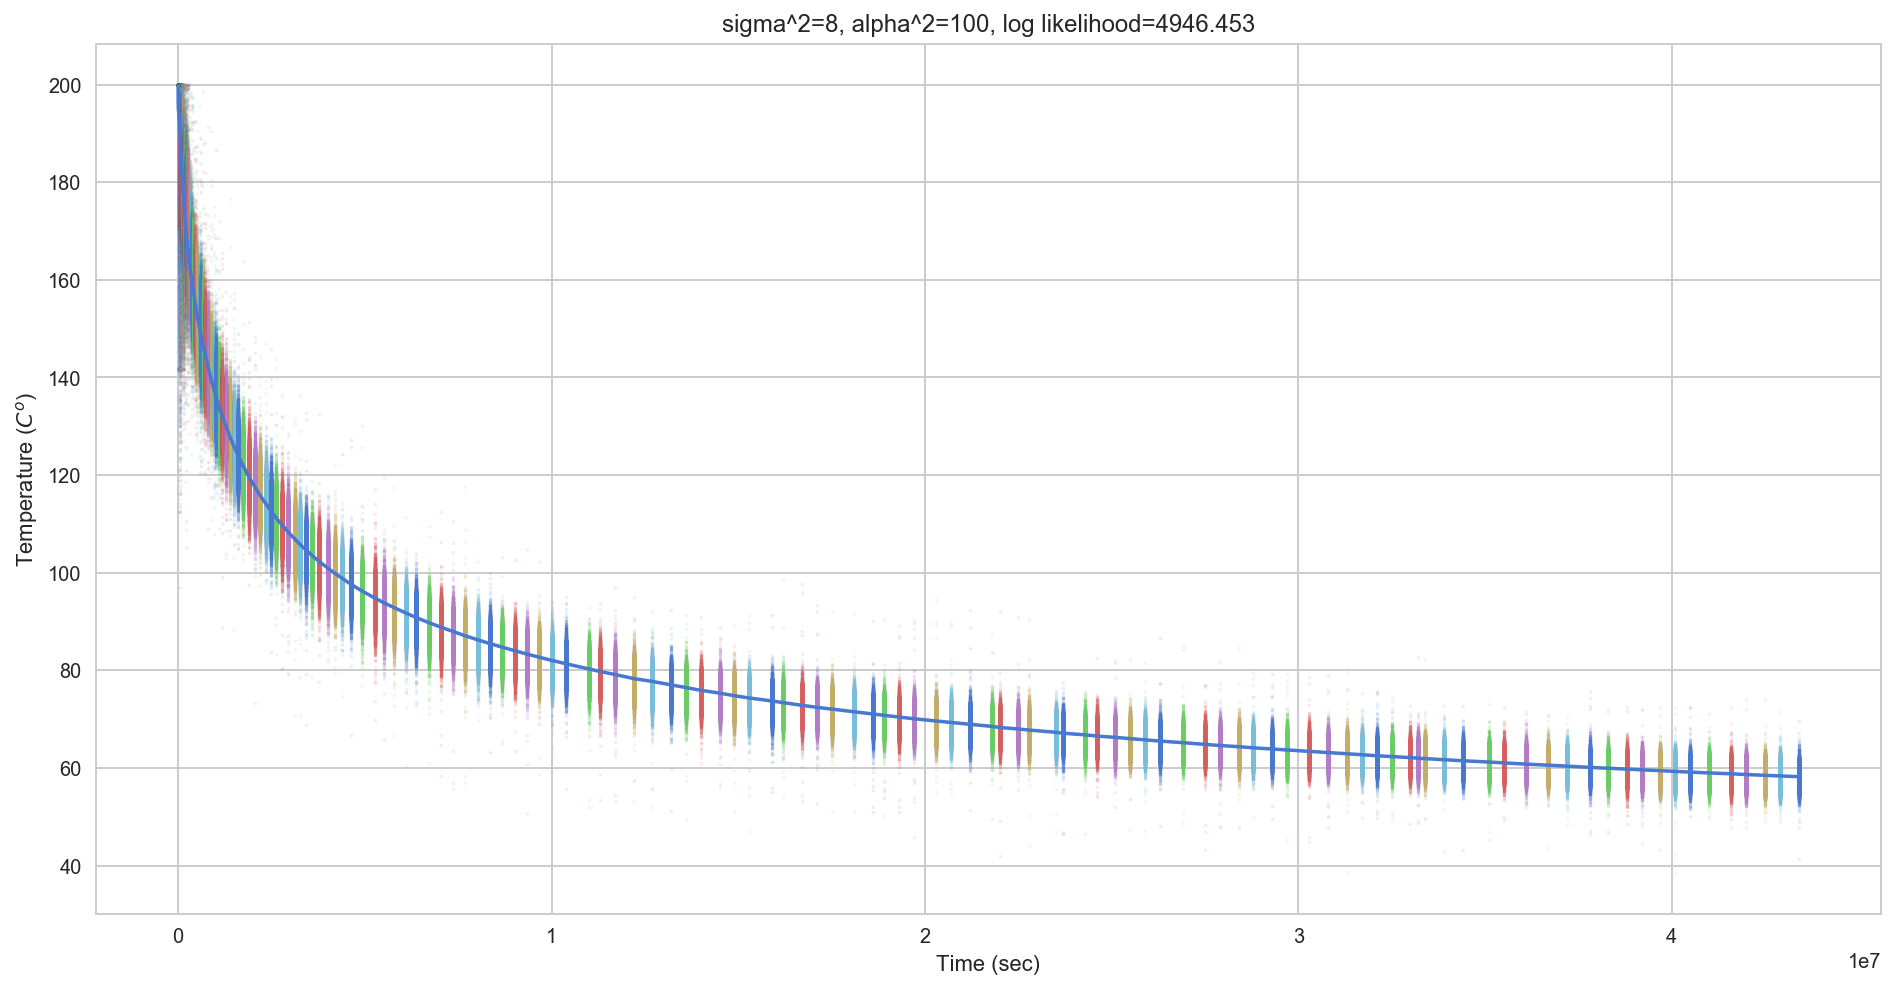

In [77]:
pf.draw_graph()
 